# Gaussian process regression

## Vittorio Orlandi, Graham Tierney, Alessandro Zito

This file runs a simulation to compare the time performance of 3 different packages for Bayesian Gaussian process regression:

1) PyStan (with script similar to the one depicted 
[here](https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html) 

2) GPy [here](https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb)

3) FIFA_GP with HODLR approximation (out own implementation). See this [paper](https://arxiv.org/pdf/2006.06537.pdf) for references 

4) Hard coded Gibbs sampler is full python (no Cpp)

The purpose of this comparison is to test the power of our implementation when using standard toold for Gaussian Process regression.

In [1]:
import pystan  # Version used: 2.19.1.1. Note that there is a sliglty different code.
import numpy as np 
import scipy
import GPy
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from timeit import timeit
import time
from fifa_gp_py.scripts.regression import FIFA_GP_R

We generate the datasets as follows:
$$x \sim N_{[-2,2]}(0,1)$$
and 
$$y = f(x) + \epsilon$$
with $$f(x) = \sin(2x) + \frac18e^{x} \qquad \epsilon \sim N(0, 1/\tau)$$
and $\tau = 1$.

In [2]:
## Useful functions

def f(x):
    """Function to compute the mean process f"""
    return np.sin(2*x) + np.exp(x)/8

def simulate_data(n, a, b, tau, scale = 1):
    """Simulate the data"""
    x = truncnorm(a/scale,b/scale, scale = scale).rvs(n)
    y = f(x) + np.random.normal(0,np.sqrt(1/tau), size = n)
    return np.c_[y, x]

def timer(f):    # time is defined with any f
    """Times how long f takes."""
    
    def g(*args, **kwargs):    # *args, **kwargs. Any arguents are good!!
        start = time.time()     
        res = f(*args, **kwargs)  # do your f function here
        elapsed = time.time() - start
        return res, elapsed # res is the output of your function
    return g

In [3]:
# Generate the datasets for the simulation
np.random.seed(191)
n_list = [100, 250, 500, 750, 1000, 2000]
a, b = -2, 2 
tau = 1

simualtion_data = {str(n_list[i]): simulate_data(n_list[i], a, b, tau) for i in range(len(n_list))}

In [4]:
y = simualtion_data["500"][:, 0]
x = simualtion_data["500"][:, 1]

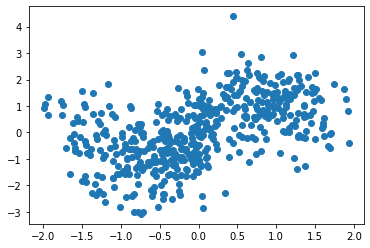

In [5]:
## Just to plot
plt.scatter(x,y)
pass

##  1) PySTAN 

In [6]:
# Let's try to use stan
stanGP = """
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
  
    // Hyperparameters for the precision tau
  real<lower = 0> a1; 
  real<lower = 0> b1; 
  
  // Hyperparameters for the squared exp. kernel sigma2_f
  real<lower = 0> a2;
  real<lower = 0> b2;
  
}
transformed data {
  vector[N] mu = rep_vector(0, N);
}
parameters {
  real<lower=0> rho;
  real<lower=0> sigma2f;
  real<lower=0> tau;
}
model {
  matrix[N, N] L_K;
  matrix[N, N] K = cov_exp_quad(x, sigma2f, rho);
  real invtau = 1/tau;

  // diagonal elements
  for (n in 1:N)
    K[n, n] = K[n, n] + invtau;

  L_K = cholesky_decompose(K);

  rho ~ inv_gamma(5, 5);
  sigma2f ~ inv_gamma(a2/2, b2/2);
  tau ~ gamma(a1/2, b1/2);

  y ~ multi_normal_cholesky(mu, L_K);
}
"""

sm = pystan.StanModel(model_code=stanGP)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57bef300b49c2c6cbc9dc3bcd0a94432 NOW.


In [7]:
@timer
def test_PyStan(stan_data, sm, n_iter):
    """Get the posterior via stan"""
    fit = sm.sampling(data=stan_data, iter=n_iter, chains=1)
    return fit

In [8]:
stan_results = {}
n_iter = 100
stan_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    x = simualtion_data[str(n)][:, 1]
    y = simualtion_data[str(n)][:, 0]

    stan_data = {"N": n, 
                "x": list(x.ravel()),
                "y" : list(y.ravel()), 
                "a1": 1, "b1": 1,
                "a2": 1, "b2": 1}

    res = test_PyStan(stan_data, sm, n_iter = n_iter)
    
    stan_results[str(n)] = res
    
    samp = res[0].extract()
    samp = np.c_[samp["tau"], samp["rho"], samp["sigma2f"]]
    name_samp = "output/Pystan/Pystan_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    stan_times[i] = res[1]

name_times = "output/Pystan/stan_times.npy"
np.save(name_times, stan_times)

0


1
2


3
4
5


## 2) GPy

In [9]:
@timer
def test_GPy(x, y, n_iter, a1=1, b1=1, a2=1, b2=1):
    """Get the posterior via GPy"""
    m = GPy.models.GPRegression(x[:, None],y[:, None])
    
    # Set Kernel prior
    m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(5.,5))
    m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(a2/2.,b2/2))
    m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(a1/2,b1/2))
    
    # Fit the model
    hmc = GPy.inference.mcmc.HMC(m,stepsize=5e-2)
    s = hmc.sample(num_samples=n_iter)
    
    return m, hmc, s

In [10]:
n = n_list[0]
x = simualtion_data[str(n)][:, 1]
y = simualtion_data[str(n)][:, 0]
res = test_GPy(x, y, n_iter=100)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


In [11]:
GPy_results = {}
n_iter = 100
GPy_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    x = simualtion_data[str(n)][:, 1]
    y = simualtion_data[str(n)][:, 0]
    res = test_GPy(x, y, n_iter=n_iter)
    
    GPy_results[str(n)] = res

    samp = res[0][2]
    name_samp = "output/GPy/GPy_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    GPy_times[i] = res[1]

name_times = "output/GPy/GPy_times.npy"
np.save(name_times, GPy_times)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


0


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


1


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


4


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


5


NameError: name 'FIFAGP_times' is not defined

In [12]:
name_times = "output/GPy/GPy_times.npy"
np.save(name_times, GPy_times)

## 3) FIFA GP

In [6]:
@timer
def test_FIFAGP(n, n_iter):
    """Timer test fornthe FIFA GP """
    
    gp = FIFA_GP_R()
    rho_choices = list(np.linspace(.5, 3, 50))
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    gp.fit(x[:, None],y[:, None],
           1,rho_choices,1,
           True,False,
           True,-1,
           1,1,1,1,
           1e-12,20,True,169,"none",
           0,n_iter,1,False)
    return gp

In [14]:
FIFAGP_results = {}
n_iter = 100
FIFAGP_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    out = test_FIFAGP(n, n_iter)
    
    ## STORE THE VALUES
    FIFAGP_results[str(n)] = out
    
    f_vals = out[0].f
    samp = out[0].get_params()
    name_f = "output/FIFAGP/FIFAGP_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_vals)
    name_samp = "output/FIFAGP/FIFAGP_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    FIFAGP_times[i] = out[1]

name_times = "output/FIFAGP/FIFAGP_times.npy"
np.save(name_times, FIFAGP_times)

0
1
2
3
4
5


In [8]:
gp = FIFA_GP_R()
rho_choices = list(np.linspace(.5, 3, 50))
y = simualtion_data["100"][:, 0]
x = simualtion_data["100"][:, 1]
gp.fit(x[:, None],y[:, None],
       1,rho_choices,1,
       True,False,
       True,-1,
       1,1,1,1,
       1e-12,20,True,169,"none",
       0,100,1,False)

In [10]:
gp.get_params_mean()

,Noise variance,Kernel Length-Scale,Kernel Variance
0,1.145965,1.441837,0.595468


## 4) Hard coded Gibbs sampler

In [6]:
def build_K(sigma2f, rho, D):
    """This function builds the Kernel for a given vector of observations."""
    n = D.shape[0]
    return sigma2f * np.exp(-rho*D) + np.eye(n) * 1e-8

def get_Proposalmatrix(rho_list):
    """Proposal probabilities"""
    nrhos = rho_list.shape[0]
    rho_ind = np.arange(nrhos)
    a = np.exp(-scipy.spatial.distance_matrix(rho_ind[:,None], rho_ind[:,None])**2)
    probMatrix = (a/a.sum(axis = 0)[:, None])
    return probMatrix

def sampleRho_MH(rho_list, D, current_ind, probMatrix, sigma2f, f):
    """ Sample one rho via MH"""
    # Sample the new index
    probs = probMatrix[current_ind]
    
    new_ind = np.random.choice(np.arange(probMatrix.shape[0]), size = 1, p = probs)[0]
    if new_ind == current_ind:
        return current_ind
    
    else:
        K_new = build_K(sigma2f, rho_list[new_ind], D)
        K_inv_new = scipy.linalg.inv(K_new)
        K_det_new = scipy.linalg.det(K_new) + 1e-8
        
        K_old = build_K(sigma2f, rho_list[current_ind], D)
        K_inv_old = scipy.linalg.inv(K_old)
        K_det_old = scipy.linalg.det(K_old) + 1e-8
        
        # Compute the MH log ratio
        lQoldToNew = np.log(probs[new_ind])
        lQnewToOld = np.log(probMatrix[new_ind, current_ind])

        quad_tmp_old =  f.T @ K_inv_old @ f
        quad_tmp_new =  f.T @ K_inv_new @ f
        llold = -0.5 * (np.log(K_det_old) + quad_tmp_old)
        llnew = -0.5 * (np.log(K_det_new) + quad_tmp_new)
        
        # Acceptance probability
        lA = llnew + lQnewToOld - llold - lQoldToNew
        
        if np.random.rand() < np.exp(lA): 
            return new_ind
        else:
            return current_ind

def Gibbs_GP(X, y, n_iter, startvals, burnin = 0):
    """Gaussian process Gibbs sampler."""
    
    # Step 00 - Create empy vectors to store the quantities
    n =  X.shape[0]
    f_vals = np.zeros((n_iter, n))
    pars = np.zeros((n_iter, 3))
    
    # Step 0 - initialize the quantities
    rho_ind = startvals["rho_ind"]
    rho_list = startvals["rho_list"]
    rho = rho_list[rho_ind]
    tau = startvals["tau"]
    sigma2f = startvals["sigma2f"]
    a1, b1  =  startvals["tau_hyper"]
    a2, b2  =  startvals["sigma2f_hyper"]
    D = scipy.spatial.distance_matrix(X[:, None],X[:, None])**2
    probMatrix = get_Proposalmatrix(rho_list)
    
    # Run the Sampler
    for i in range(n_iter + burnin):
        
        ## Step 1 - Build K and sample f
        K = build_K(sigma2f, rho, D) 

        K_inv =  scipy.linalg.inv(K)
        K_Ktau_inv = K @ np.linalg.inv(K + np.eye(n)/tau)
        
        f = np.random.multivariate_normal(mean = K_Ktau_inv @ y, cov = tau * K_Ktau_inv, size=1)[0]
       
        ## Step 2 - Sample tau
        tau_rate = 0.5*(b1 + np.sum((y-f)**2))
        tau = np.random.gamma(size = 1, shape = 0.5*(a1 + n), scale = 1/tau_rate)
        
        # Step 3 - Sample sigma2f
        sigma2f_rate = 0.5*(b2 + sigma2f*f.T @ K_inv @ f)
        sigma2f_inv = np.random.gamma(size = 1, shape = 0.5*(a2 + n), scale = 1/sigma2f_rate)
        sigma2f = 1/sigma2f_inv
        
        # Step 4 - Sample rho with a Metropolis step
        rho_ind = sampleRho_MH(rho_list, D, current_ind = rho_ind, probMatrix = probMatrix, sigma2f=sigma2f, f=f)
        rho =  rho_list[rho_ind]
        
        # Save the quantities
        f_vals[i] = f.ravel()
        pars[i, 0] = tau
        pars[i, 1] = rho
        pars[i, 2] = sigma2f
    
    return f_vals, pars

@timer
def test_GibbsSampler(simualtion_data, n, n_iter):
    """Test the Gibbs sampler"""
    # Hardcode the starting values
    startvals = {"rho_ind":0, 
             "rho_list": np.linspace(0.5, 2.5, 50), 
             "tau" : 1,
             "sigma2f" : 1,
             "tau_hyper" : (1,1),
             "sigma2f_hyper" :(1,1)}
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    f_vals, post_pars = Gibbs_GP(x, y, n_iter, startvals)
    return f_vals, post_pars

In [14]:
startvals = {"rho_ind":0, 
             "rho_list": np.linspace(0.5, 2.5, 50), 
             "tau" : 1,
             "sigma2f" : 1,
             "tau_hyper" : (1,1),
             "sigma2f_hyper" :(1,1)}
y = simualtion_data["250"][:, 0]
x = simualtion_data["250"][:, 1]
n_iter  = 100

In [18]:
%prun -q -D Gibbs_profiler.prof Gibbs_GP(x, y, n_iter, startvals)

 
*** Profile stats marshalled to file 'Gibbs_profiler.prof'. 


In [16]:
import pstats
p = pstats.Stats('Gibbs_profiler.prof')
p.print_stats()
pass

Fri Apr 23 19:22:54 2021    Gibbs_profiler.prof

         20250 function calls (19750 primitive calls) in 3.295 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      124    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
       62    0.000    0.000    0.000    0.000 {method 'sort' of 'list' objects}
      662    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
      502    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
      200    0.014    0.000    0.014    0.000 {built-in method builtins.abs}
        1    0.000    0.000    3.295    3.295 {built-in method builtins.exec}
      748    0.001    0.000    0.001    0.000 {built-in method builtins.getattr}
      200    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
      650    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
      900    0.001    0.000    0.001    0.000 {bui

In [16]:
Gibbs_results = {}
Gibbs_times = np.zeros(len(n_list))
n_iter = 100
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    out = test_GibbsSampler(simualtion_data, n, n_iter)
    ## STORE THE VALUES
    Gibbs_results[str(n)] = out
    
    f_vals = out[0][0]
    samp = out[0][1]
    name_f = "output/Gibbs/Gibbs_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_vals)
    name_samp = "output/Gibbs/Gibbs_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    Gibbs_times[i] = out[1]

name_times = "output/Gibbs/Gibbs_times.npy"
np.save(name_times, Gibbs_times)

0
1
2
3
4
5


#### Plots

In [97]:
import seaborn as sns
import pandas as pd
sns.set_style("ticks")

In [178]:
df_times = pd.DataFrame({"FIFAGP": np.load("output/FIFAGP/FIFAGP_times.npy"), 
           "Gibbs (Python)": np.load("output/Gibbs/Gibbs_times.npy"),
           "GPy": np.load("output/GPy/GPy_times.npy"), 
           "PyStan": np.load("output/Pystan/stan_times.npy"), 
           "n": n_list}).melt("n", value_name = "time (seconds)", var_name="method")

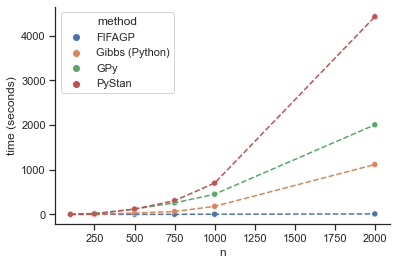

In [179]:
sns.scatterplot(data = df_times, x = "n", y = "time (seconds)", hue = "method")
sns.lineplot(data = df_times, x = "n", y = "time (seconds)", hue = "method",  linestyle='--', legend=False)
sns.despine()
pass

In [115]:
def samplef_stan(x,y, samp):
    """sample from the posterior of f from a stan output"""
    D = scipy.spatial.distance_matrix(x[:, None],x[:, None])**2
    n = x.shape[0]
    f_vals = np.zeros((samp.shape[0], n))
    for i in range(samp.shape[0]):
        sigma2f = samp[i, 2]
        rho = (1/(2*(samp[i, 1]**2)))
        tau = samp[i, 0]
        K = build_K(sigma2f, rho, D)
        K_Ktau_inv = K @ np.linalg.inv(K + np.eye(n)/tau) 
        f = np.random.multivariate_normal(mean = K_Ktau_inv @ y, cov = tau * K_Ktau_inv, size=1)[0]
        f_vals[i] = f
    return f_vals

In [119]:
def samplef_GPy(x, y, samp):
    """sample from the posterior of f from a stan output"""
    D = scipy.spatial.distance_matrix(x[:, None],x[:, None])**2
    n = x.shape[0]
    f_vals = np.zeros((samp.shape[0], n))
    for i in range(samp.shape[0]):
        sigma2f = samp[i, 0]
        rho = (1/2*samp[i, 1])
        tau = 1/samp[i, 2]
        K = build_K(sigma2f, rho, D)
        K_Ktau_inv = K @ np.linalg.inv(K + np.eye(n)/tau) 
        f = np.random.multivariate_normal(mean = K_Ktau_inv @ y, cov = tau * K_Ktau_inv, size=1)[0]
        f_vals[i] = f
    return f_vals

In [183]:
# Let's look at the plots now
n = 500
y = simualtion_data[str(n)][:, 0]
x = simualtion_data[str(n)][:, 1]

# FIFA GP
fifa = np.load("output/FIFAGP/FIFAGP_sampler_fout_" + str(n) + ".npy").mean(axis = 1)

# Gibbs
gibbs = np.load("output/Gibbs/Gibbs_sampler_fout_" + str(n) + ".npy").mean(axis = 0)

# Stan 
samp = np.load("output/Pystan/Pystan_sampler_postpars_" + str(n) + ".npy")
f_stan = samplef_stan(x, y, samp).mean(axis = 0)

# GPy 
samp = np.load("output/GPy/GPy_sampler_postpars_" + str(n) + ".npy")
f_GPy = samplef_GPy(x, y, samp).mean(axis = 0)

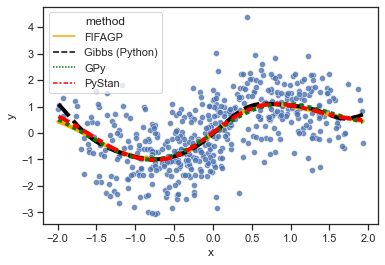

In [184]:
df_samps = pd.DataFrame({"FIFAGP": fifa, 
           "Gibbs (Python)": gibbs,
           "GPy": f_GPy, 
           "PyStan": f_stan, 
           "x": x}).melt("x", value_name = "f", var_name="method")
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y",alpha = 0.8)
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = ["orange", "black", "green", "red"])
pass